In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define all the constants
experiment_T1 = 268.15
experiment_T2 = 298.15
experiment_c1 = 0.56350
experiment_c2 = 0.56486
experiment_k1 = 0.56401
experiment_k2 = 0.59526

c = (experiment_c1 + experiment_c2) / 2

gas_constant_R = 8.314 * 10**-3 # KJ/mol*K
# arrenhius_Ea_temperature = findEa(gas_constant_R, experiment_k1, experiment_k2, experiment_T1, experiment_T2)

experiment_Kb = 0.0375
experiment_Rb = 0.070
experiment_tb = 0.954
experiment_B = 18
experiment_Expt0 = 0.280

# Function is limited to -5 <= T_celcius <= 40
def cf(cf_input_T):
    if -5.0 <= cf_input_T < 10.0:
        cf_a = -5.1170 * np.power(10.0, -7.0)
        cf_b = 0
        cf_c = 1.0076 * np.power(10.0, -3.0)
        cf_d = 9.9800 * np.power(10.0, -1.0)
        cf_T1 = -5.0
    elif 10.0 <= cf_input_T < 25.0:
        cf_a = 2.2375 * np.power(10.0, -6.0)
        cf_b = -2.3027 * np.power(10.0, -5.0)
        cf_c = 6.6220 * np.power(10.0, -4.0)
        cf_d = 1.0114
        cf_T1 = 10.0
    elif 25.0 <= cf_input_T < 32.5:
        cf_a = -2.0925 * np.power(10.0, -5.0)
        cf_b = 7.7663 * np.power(10.0, -5.0)
        cf_c = 1.4817 * np.power(10.0, -3.0)
        cf_d = 1.0237
        cf_T1 = 25.0
    elif 32.5 <= cf_input_T < 40.0:
        cf_a = 1.7473 * np.power(10.0, -5.0)
        cf_b = -3.9315 * np.power(10.0, -4.0)
        cf_c = -8.8444 * np.power(10.0, -4.0)
        cf_d = 1.0303
        cf_T1 = 32.5
    else:
        raise ValueError("T_celsius must be between -5 and 40")

    return cf_a * np.power(cf_input_T - cf_T1, 3.0) + cf_b * np.power(cf_input_T - cf_T1, 2.0) + cf_c * (cf_input_T - cf_T1) + cf_d

def kibam(kibam_i0, kibam_j0, kibam_k, kibam_c, kibam_dt, kibam_I):
    kibam_result_y0 = kibam_i0 + kibam_j0
    kibam_result_kt = np.exp(-kibam_k * kibam_dt)

    kibam_result_i = kibam_i0 * kibam_result_kt + ((kibam_result_y0 * kibam_k * kibam_c - kibam_I) * (1 - kibam_result_kt)) / kibam_k - (kibam_I * kibam_c * (kibam_k * kibam_dt - 1 + kibam_result_kt)) / kibam_k
    kibam_result_j = kibam_j0 * kibam_result_kt + kibam_result_y0 * (1 - kibam_c) * (1 - kibam_result_kt) - (kibam_I * (1 - kibam_c) * (kibam_k * kibam_dt - 1 + kibam_result_kt)) / kibam_k
    return kibam_result_i, kibam_result_j

def kibam_voltage(kibam_voltage_input_E0, kibam_voltage_input_Emin, kibam_voltage_input_I, kibam_voltage_input_i, kibam_voltage_input_R, kibam_voltage_input_imax):
    kibam_voltage_result_E = kibam_voltage_input_Emin + (kibam_voltage_input_E0 - kibam_voltage_input_Emin) * kibam_voltage_input_i / kibam_voltage_input_imax
    kibam_voltage_result_V = kibam_voltage_result_E - kibam_voltage_input_I * kibam_voltage_input_R
    return kibam_voltage_result_V

def arrhenius(arrhenius_input_A, arrhenius_input_Ea, arrhenius_input_T):
    return arrhenius_input_A * np.exp(-arrhenius_input_Ea / (gas_constant_R * (arrhenius_input_T + 273.15)))

def findEa(ea_input_R, ea_input_k1, ea_input_k2, ea_input_T1, ea_input_T2):
    return (ea_input_R * np.log(ea_input_k2 / ea_input_k1)) / (1 / ea_input_T1 - 1 / ea_input_T2)

def tvm(tvm_input_E0, tvm_input_Rb, tvm_input_i, tvm_input_K, tvm_input_Q, tvm_input_it, tvm_input_dt, tvm_input_B, tvm_input_tau, tvm_input_expt):
    def Qc(qc_input_Q, qc_input_it, qc_input_tau):
        return qc_input_Q / (qc_input_Q - qc_input_it * qc_input_tau)
    def Exp(exp_input_B, exp_input_i, exp_input_dt, exp_input_tau, exp_input_expt):
        return (1 / (1 + exp_input_tau * exp_input_B * exp_input_dt * np.abs(exp_input_i))) * exp_input_expt
    v = tvm_input_E0 - tvm_input_Rb * tvm_input_i - tvm_input_K * Qc(tvm_input_Q, tvm_input_it, tvm_input_tau) * (tvm_input_it * tvm_input_tau + tvm_input_i) + tvm_input_expt
    exp = Exp(tvm_input_B, tvm_input_i, tvm_input_dt, tvm_input_tau, tvm_input_expt)
    return v, exp

def t_kibam(input_battery_q0, input_time, input_temperature, input_c, input_Emin, input_I, debug=False):
    input_arrhenius_E0 = arrhenius(2.884200, 0.25714, input_temperature)
    input_arrhenius_Rb = arrhenius(0.000071, -15.358, input_temperature)
    input_arrhenius_Kb = arrhenius(0.000234, -11.318, input_temperature)
    input_arrhenius_B  = arrhenius(0.584660, -7.6403, input_temperature)
    input_arrhenius_Expt0 = arrhenius(0.082728, -2.7181, input_temperature)
    input_arrhenius_tau = arrhenius(1.126800, 0.36978, input_temperature)
    # the return value from the arrhenius function is in s^-1, thus we multiply it to get it in h^-1
    result_t_kibam_k = arrhenius(0.96397, 1.1949, input_temperature) * 3600
    corrected_q0 = input_battery_q0 * cf(input_temperature)

    i = input_c * corrected_q0
    j = (1 - input_c) * corrected_q0
    y = i + j
    t = 0
    result_kibam_voltage = []
    result_t_kibam_voltage = []
    expt = input_arrhenius_Expt0
    while i > 0:

        kv = kibam_voltage(input_arrhenius_E0 + input_arrhenius_Expt0, input_Emin, input_I, y, input_arrhenius_Rb, corrected_q0)
        result_kibam_voltage.append(kv)
        (v, expt) = tvm(input_arrhenius_E0, input_arrhenius_Rb, input_I, input_arrhenius_Kb, corrected_q0, input_I * t, input_time, input_arrhenius_B, input_arrhenius_tau, expt)
        result_t_kibam_voltage.append(v)

        if debug:
            print(f"i: {i:.4f}, j: {j:.2f}, y: {y:.4f}, t: {t:.2f}, v: {v:.2f}, kv: {kv:.2f}")

        (i, j) = kibam(i, j, result_t_kibam_k, input_c, input_time, input_I)
        y = i + j
        t += input_time

    return result_kibam_voltage, result_t_kibam_voltage

def get_time_axis(time_interval, result):
    plot = []
    for l in range(0, len(result)):
        plot.append(time_interval * l)
    return plot

Correction factor is just differentiating the discharge current over time, to get the overall used capacity, and compare that to the design capacity

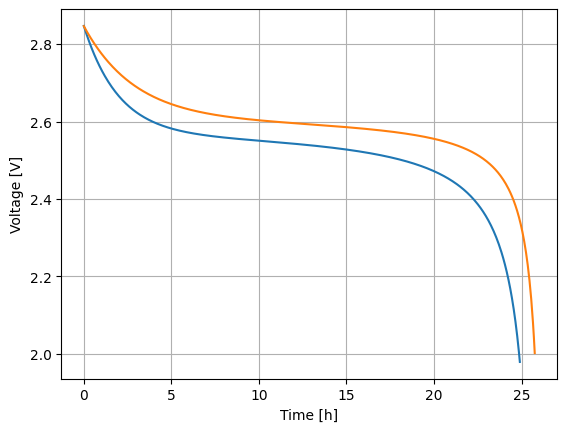

In [3]:
def t_kibam_arrenhius():
    experiment_temperature = -5
    experiment_I = 0.030
    experiment_Emin = 2.0 # E is in V
    experiment_q0 = 0.75 # Q is in Ah

    dt = 0.05 # dt is in h

    (kibam_result_5, tkibam_result_5) = t_kibam(experiment_q0, dt, -5, c, experiment_Emin, experiment_I)
    (kibam_result_32, tkibam_result_32) = t_kibam(experiment_q0, dt, 32.5, c, experiment_Emin, experiment_I)
    t_plot_5 = get_time_axis(dt, kibam_result_5)
    t_plot_32 = get_time_axis(dt, kibam_result_32)

    # plt.plot(t_plot_5, kibam_result_5)
    plt.plot(t_plot_5, tkibam_result_5)
    # plt.plot(t_plot_32, kibam_result_32)
    plt.plot(t_plot_32, tkibam_result_32)
    plt.ylabel('Voltage [V]')
    plt.xlabel('Time [h]')
    plt.grid()
    plt.yticks()
    plt.show()

t_kibam_arrenhius()

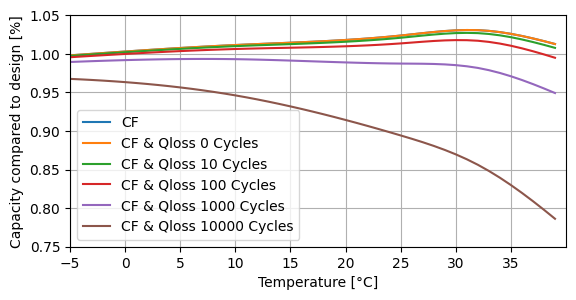

In [75]:
def calc_q_loss(calc_qloss_input_temperature, calc_qloss_input_cycles, calc_qloss_input_dod, calc_qloss_input_capacity):
    z = 0.552
    return arrhenius(30330, 31.500, calc_qloss_input_temperature) * np.power(calc_qloss_input_capacity * calc_qloss_input_dod * calc_qloss_input_cycles, z)

def calc_q_factor(calc_qfactor_input_temperature, calc_qfactor_input_cycles, calc_qfactor_input_dod, calc_qfactor_input_capacity):
    return cf(calc_qfactor_input_temperature) * (1-(calc_q_loss(calc_qfactor_input_temperature, calc_qfactor_input_cycles, calc_qfactor_input_dod, calc_qfactor_input_capacity) / 100.0))

# generate a plot for the CF with respect to temperature
def calc_CF_plot(T_min, T_max):
    iterations = (T_max - T_min)
    cf_plot = np.empty(iterations)
    T_plot = np.empty(iterations)

    T = T_min
    j = 0
    while T < T_max:
        cf_plot[j] = cf(T)
        T_plot[j] = T
        j += 1
        T += 1

    return cf_plot, T_plot

# generate a plot for the Q-loss with respect to temperature for a given Ah throughput
def calc_qloss_plot(T_min, T_max, ah):
    iterations = (T_max - T_min)
    qloss_plot = np.empty(iterations)
    T_plot = np.empty(iterations)

    T = T_min
    j = 0
    while T < T_max:
        qloss_plot[j] = calc_q_factor(T, ah, 1, 0.75)
        T_plot[j] = T
        j += 1
        T += 1

    return qloss_plot, T_plot

# plot the CF and Q-loss with respect to temperature (Q-loss with different Ah throughput's)
def plot_cf_qloss_temp():
    (cf_plot, T_plot) = calc_CF_plot(-5, 40)
    (qloss_plot_0, T_plot_0) = calc_qloss_plot(-5, 40, 0)
    (qloss_plot_10, T_plot_10) = calc_qloss_plot(-5, 40, 10)
    (qloss_plot_100, T_plot_100) = calc_qloss_plot(-5, 40, 100)
    (qloss_plot_1000, T_plot_1000) = calc_qloss_plot(-5, 40, 1_000)
    (qloss_plot_10000, T_plot_10000) = calc_qloss_plot(-5, 40, 10_000)

    plt.plot(T_plot, cf_plot)
    plt.plot(T_plot, qloss_plot_0)
    plt.plot(T_plot, qloss_plot_10)
    plt.plot(T_plot, qloss_plot_100)
    plt.plot(T_plot, qloss_plot_1000)
    plt.plot(T_plot, qloss_plot_10000)
    plt.legend(['CF', 'CF & Qloss 0 Cycles', 'CF & Qloss 10 Cycles', 'CF & Qloss 100 Cycles', 'CF & Qloss 1000 Cycles', 'CF & Qloss 10000 Cycles'])
    plt.ylim(0.75, 1.05)
    plt.xlim(-5, 40)
    plt.yticks(np.arange(0.75, 1.05, 0.05))
    plt.xticks(np.arange(-5, 40, 5))
    plt.grid()
    plt.ylabel('Capacity compared to design [%]')
    plt.xlabel('Temperature [°C]')
    plt.gca().set_aspect(70)

def t_kibam_qloss(input_battery_q0, input_time, input_temperature, input_c, input_Emin, input_I, input_dod, input_cycles, debug=False):
    input_arrhenius_E0 = arrhenius(2.884200, 0.25714, input_temperature)
    input_arrhenius_Rb = arrhenius(0.000071, -15.358, input_temperature)
    input_arrhenius_Kb = arrhenius(0.000234, -11.318, input_temperature)
    input_arrhenius_B  = arrhenius(0.584660, -7.6403, input_temperature)
    input_arrhenius_Expt0 = arrhenius(0.082728, -2.7181, input_temperature)
    input_arrhenius_tau = arrhenius(1.126800, 0.36978, input_temperature)
    # the return value from the arrhenius function is in s^-1, thus we multiply it to get it in h^-1
    result_t_kibam_k = arrhenius(0.96397, 1.1949, input_temperature) * 3600
    debug_cf = cf(input_temperature)
    debug_qloss = calc_q_factor(input_temperature, input_cycles, input_dod, input_battery_q0)
    corrected_q0 = input_battery_q0 * calc_q_factor(input_temperature, input_cycles, input_dod, input_battery_q0)
    if debug:
        print(f"corrected_q0: {corrected_q0}, cf: {debug_cf}, qloss: {debug_qloss}")

    i = input_c * corrected_q0
    j = (1 - input_c) * corrected_q0
    y = i + j
    t = 0
    result_kibam_voltage = []
    result_t_kibam_voltage = []
    expt = input_arrhenius_Expt0
    while i > 0:

        kv = kibam_voltage(input_arrhenius_E0 + input_arrhenius_Expt0, input_Emin, input_I, y, input_arrhenius_Rb, corrected_q0)
        result_kibam_voltage.append(kv)
        (v, expt) = tvm(input_arrhenius_E0, input_arrhenius_Rb, input_I, input_arrhenius_Kb, corrected_q0, input_I * t, input_time, input_arrhenius_B, input_arrhenius_tau, expt)
        result_t_kibam_voltage.append(v)

        if v < input_Emin:
            break

        # if debug:
        #     print(f"i: {i:.4f}, j: {j:.2f}, y: {y:.4f}, t: {t:.2f}, v: {v:.2f}, kv: {kv:.2f}")

        (i, j) = kibam(i, j, result_t_kibam_k, input_c, input_time, input_I)
        y = i + j
        t += input_time

    return result_kibam_voltage, result_t_kibam_voltage

def t_kibam_arrenhius_qloss():
    experiment_temperature = 35
    experiment_I = 0.030
    experiment_Emin = 2.0 # E is in V
    experiment_q0 = 0.75 # Q is in Ah
    experiment_qloss_dod = 1
    experiment_qloss_cycles = 10_000

    dt = 0.05 # dt is in h

    experiment_temperature_range = [-5, 35]
    experiment_cycle_range = [0, 10, 100, 1_000, 10_000]

    for plot_id in range(0, 2):
        temperature_range = experiment_temperature_range[plot_id]

        
        labels = []
        plt.subplot(2, 1, plot_id + 1)
        for cycle_range in experiment_cycle_range:
            (kibam_result, tkibam_result) = t_kibam_qloss(experiment_q0, dt, temperature_range, c, experiment_Emin, experiment_I, experiment_qloss_dod, cycle_range, debug=False)
            t_plot = get_time_axis(dt, kibam_result)

            labels.append(f"{cycle_range} cycles")
            # plt.plot(t_plot, kibam_result)
            plt.plot(t_plot, tkibam_result)

        plt.legend(labels)
        plt.ylabel('Voltage [V]')
        if plot_id == 1:
            plt.xlabel('Time [h]')
        plt.text(21.5, 2.8, f"Temperature {temperature_range}°C", fontsize=12, bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center', verticalalignment='top')
        plt.grid()
        plt.yticks()

    # plt.tight_layout()
    plt.show()

plot_cf_qloss_temp()
# t_kibam_arrenhius_qloss()